# LPN-wx

This notebook provides simplified [LPN](https://github.com/wtyhub/LPN)'s code for study and research purpose.

Here we use (verify between epoch) image augment to train model

In [2]:
from __future__ import print_function, division

import os
import math
from shutil import copyfile

import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.backends.cudnn as cudnn
from torchvision.transforms import InterpolationMode

os.environ['TORCH_HOME']='./'

c:\Users\lyq\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
import imgaug.augmenters as iaa
import numpy as np
import torch.utils.data as Data
from LPN.image_folder import *

environments = {'normal': iaa.Sequential([iaa.Noop()]),
                'dark' : iaa.Sequential([
                                        # iaa.BlendAlpha(0.5, foreground=iaa.Add(100), background=iaa.Multiply(0.2), seed=31),
                                        iaa.MultiplyAndAddToBrightness(mul=0.4, add=-15, seed=1991)]),
                'fog'  : iaa.Sequential([iaa.CloudLayer(intensity_mean=225, intensity_freq_exponent=-2, intensity_coarse_scale=2, alpha_min=1.0,
                                        alpha_multiplier=0.9, alpha_size_px_max=10, alpha_freq_exponent=-2, sparsity=0.9, density_multiplier=0.5, seed=35)]),
                'rain' : iaa.Sequential([iaa.Rain(drop_size=(0.05, 0.1), speed=(0.04, 0.06), seed=38),
                                        iaa.Rain(drop_size=(0.05, 0.1), speed=(0.04, 0.06), seed=35),
                                        iaa.Rain(drop_size=(0.1, 0.2), speed=(0.04, 0.06), seed=73),
                                        iaa.Rain(drop_size=(0.1, 0.2), speed=(0.04, 0.06), seed=93),
                                        iaa.Rain(drop_size=(0.05, 0.2), speed=(0.04, 0.06), seed=95)]),
                'snow' : iaa.Sequential([iaa.Snowflakes(flake_size=(0.5, 0.8), speed=(0.007, 0.03), seed=38),
                                        iaa.Snowflakes(flake_size=(0.5, 0.8), speed=(0.007, 0.03), seed=35),
                                        iaa.Snowflakes(flake_size=(0.6, 0.9), speed=(0.007, 0.03), seed=74),
                                        iaa.Snowflakes(flake_size=(0.6, 0.9), speed=(0.007, 0.03), seed=94),
                                        iaa.Snowflakes(flake_size=(0.5, 0.9), speed=(0.007, 0.03), seed=96)]),
                'fog_rain' : iaa.Sequential([iaa.CloudLayer(intensity_mean=225, intensity_freq_exponent=-2, intensity_coarse_scale=2, alpha_min=1.0,
                                            alpha_multiplier=0.9, alpha_size_px_max=10, alpha_freq_exponent=-2, sparsity=0.9, density_multiplier=0.5, seed=35),
                                            iaa.Rain(drop_size=(0.05, 0.2), speed=(0.04, 0.06), seed=35),
                                            iaa.Rain(drop_size=(0.05, 0.2), speed=(0.04, 0.06), seed=36)]),
                'fog_snow' : iaa.Sequential([iaa.CloudLayer(intensity_mean=225, intensity_freq_exponent=-2, intensity_coarse_scale=2, alpha_min=1.0,
                                            alpha_multiplier=0.9, alpha_size_px_max=10, alpha_freq_exponent=-2, sparsity=0.9, density_multiplier=0.5, seed=35),
                                            iaa.Snowflakes(flake_size=(0.5, 0.9), speed=(0.007, 0.03), seed=35),
                                            iaa.Snowflakes(flake_size=(0.5, 0.9), speed=(0.007, 0.03), seed=36)]),
                'rain_snow' : iaa.Sequential([iaa.Snowflakes(flake_size=(0.5, 0.8), speed=(0.007, 0.03), seed=35),
                                            iaa.Rain(drop_size=(0.05, 0.1), speed=(0.04, 0.06), seed=35),
                                            iaa.Rain(drop_size=(0.1, 0.2), speed=(0.04, 0.06), seed=92),
                                            iaa.Rain(drop_size=(0.05, 0.2), speed=(0.04, 0.06), seed=91),
                                            iaa.Snowflakes(flake_size=(0.6, 0.9), speed=(0.007, 0.03), seed=74)]),
                'light': iaa.Sequential([iaa.MultiplyAndAddToBrightness(mul=1.6, add=(0, 30), seed=1992)]),
                'wind' : iaa.Sequential([iaa.MotionBlur(15, seed=17)])
                }

class WeatherTransform:
    def __init__(self, aug='normal') -> None:
        self.transform = environments[aug]

    def __call__(self, img):
        img = np.array(img) # input is PIL
        img = self.transform(image=img)
        img = Image.fromarray(img)
        return img
    

class MyDataset(datasets.ImageFolder):
    # enable various weather enhancement
    # use for drone-view only
    def __init__(self, root, transform = None, target_transform = None, style='normal', stage='train', h=384, w=384, pad=10):
        super().__init__(root, transform = transform, target_transform = target_transform)
        self.envir_list = [i for i in environments]
        self.style_list = self.envir_list + ['mixed']
        assert style in self.style_list, f"style must be one of {self.style_list}"
        assert stage in ['train', 'test'], f"style must be one of {['train', 'test']}"
        self.style = style 
        self.stage = stage
        # transform setting
        self.h = h 
        self.w = w 
        self.pad = pad 

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        # enhance image according to self.style 
        h = self.h 
        w = self.w 
        pad = self.pad 

        if self.style=='mixed':
            weather = np.random.choice(self.envir_list)
        else:
            weather = self.style


        if self.stage=='train':
            t = transforms.Compose(
                [
                    transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC), 
                    WeatherTransform(aug=weather),
                    transforms.Pad( pad, padding_mode='edge'),
                    transforms.RandomCrop((h, w)),
                    transforms.RandomHorizontalFlip(),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        else:
            t = transforms.Compose(
                [
                    transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC),
                    WeatherTransform(aug=weather),
                    transforms.ToTensor(),
                    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
                ]
            )
        
        img = t(img)
        return img, target, weather    

    def __len__(self):
        return len(self.imgs)


Test custom dataset(skip freely)

tensor([532, 665,  63, 484,  60, 261, 396, 530])
('light', 'light', 'normal', 'fog', 'rain_snow', 'fog', 'rain', 'dark')


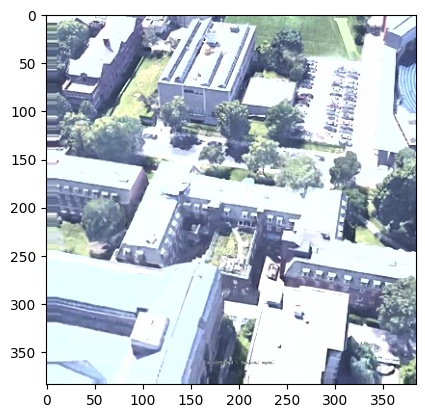

In [3]:
a = MyDataset(os.path.join(os.getcwd(), 'University-Release', 'train', 'drone'), style='mixed', stage='train')

from matplotlib import pyplot as plt
import numpy as np

def imshow(img):
    img = img * torch.tensor([0.229, 0.224, 0.225]).view(3,1,1) + torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    img = img.numpy()
    plt.imshow(np.transpose(img, (1,2,0)))
    plt.show() 

d = torch.utils.data.DataLoader(a, batch_size=8, shuffle=True, num_workers=0, pin_memory=False)
dataiter = iter(d)
img, label, weather = dataiter.next()
#print(img.shape)
print(label)
print(weather)

imshow(img[0])

## CONVERT IMAGE TO TENSOR

In [4]:
from LPN.folder import ImageFolder
from LPN.image_folder import customData

def init_dataset_train(name='University-Release', w=384, h=384, pad=10, batchsize=8, style='mixed', num_worker=4):

    data_transforms = {
        'train': transforms.Compose(
            [
                transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC), 
                transforms.Pad( pad, padding_mode='edge'),
                transforms.RandomCrop((h, w)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        ),
        'val': transforms.Compose(
            [
                transforms.Resize(size=(h, w),interpolation=InterpolationMode.BICUBIC), 
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        ),
        'satellite': transforms.Compose(
            [
                transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC),
                transforms.Pad( pad, padding_mode='edge'),
                transforms.RandomAffine(90),
                transforms.RandomCrop((h, w)),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
            ]
        ) 
    }   

    image_datasets = {
        'satellite': datasets.ImageFolder(os.path.join(os.getcwd(), name, 'train', 'satellite'), data_transforms['satellite']),
        'street': datasets.ImageFolder(os.path.join(os.getcwd(), name, 'train', 'street'), data_transforms['train']),
        'drone': MyDataset(os.path.join(os.getcwd(), name, 'train', 'drone'), style=style, stage='train',h=h, w=w, pad=pad),
        'google': ImageFolder(os.path.join(os.getcwd(), name, 'train', 'google'), data_transforms['train'])
    }

    dataloaders = {
        'satellite': torch.utils.data.DataLoader(image_datasets['satellite'], batch_size=batchsize, shuffle=True, num_workers=num_worker, pin_memory=False),
        'street': torch.utils.data.DataLoader(image_datasets['street'], batch_size=batchsize, shuffle=True, num_workers=num_worker, pin_memory=False),
        'drone': torch.utils.data.DataLoader(image_datasets['drone'], batch_size=batchsize, shuffle=True, num_workers=0, pin_memory=False), # Must 0 here
        'google': torch.utils.data.DataLoader(image_datasets['google'], batch_size=batchsize, shuffle=True, num_workers=num_worker, pin_memory=False),
    }

    dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
    return image_datasets, dataloaders, dataset_sizes

def init_dataset_test(name='University-Release', w=384, h=384, batchsize=128, style='mixed', num_worker=16):
    query_list = ['query_satellite', 'query_drone', 'query_street']
    gallery_list = ['gallery_satellite','gallery_drone', 'gallery_street']

    data_transforms = transforms.Compose([
        transforms.Resize((h, w), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_datasets = {x: MyDataset(os.path.join(os.getcwd(), name, 'test', x), style=style, stage='test',h=h, w=w)
                      if 'drone' in x 
                      else datasets.ImageFolder( os.path.join(name, 'test', x) ,data_transforms) 
                      for x in (query_list+gallery_list)}

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=False, num_workers=0) 
                   if 'drone' in x 
                   else torch.utils.data.DataLoader(image_datasets[x], batch_size=batchsize, shuffle=False, num_workers=num_worker) 
                   for x in (query_list+gallery_list)}

    dataset_sizes = {x: len(image_datasets[x]) for x in image_datasets}
    return image_datasets, dataloaders, dataset_sizes

Test custom init function(skip freely)

tensor([120, 207, 115])
('rain', 'rain', 'rain')


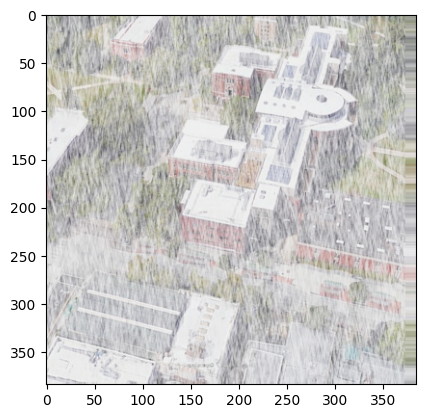

In [11]:
from matplotlib import pyplot as plt
import numpy as np

image_datasets, dataloaders, dataset_sizes = init_dataset_train(batchsize=3, style='rain')
dataiter = iter(dataloaders['drone'])
img, label, tag = dataiter.next()
#print(img.shape)
print(label)
print(tag)
imshow(img[0])

tensor([0, 0, 0])
('dark', 'rain_snow', 'fog_snow')


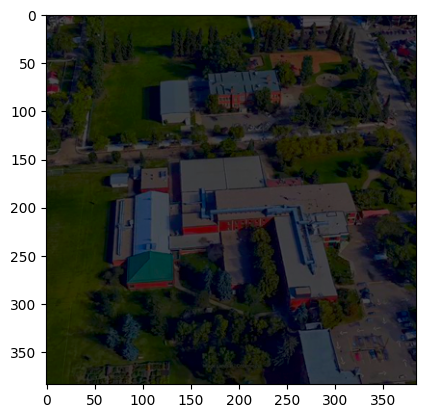

In [16]:
image_datasets, dataloaders, dataset_sizes = init_dataset_test(batchsize=3, style='mixed')
dataiter = iter(dataloaders['query_drone'])
img2, label2, tag2 = dataiter.next()
#print(img.shape)
print(label2)
print(tag2)
imshow(img2[0])


## Backbone (Resnet+LPN)

In [5]:
from torchvision import models
from torch.nn import functional as F

class ft_net_LPN(nn.Module):

    def __init__(self, class_num, droprate=0.5, stride=2, init_model=None, pool='avg', block=6):
        super(ft_net_LPN, self).__init__()
        model_ft = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
        # avg pooling to global pooling
        if stride == 1:
            model_ft.layer4[0].downsample[0].stride = (1,1)
            model_ft.layer4[0].conv2.stride = (1,1)

        self.pool = pool
        self.model = model_ft
        self.block = block
        if init_model!=None:
            self.model = init_model.model
            self.pool = init_model.pool
            #self.classifier.add_block = init_model.classifier.add_block

    def forward(self, x):
        x = self.model.conv1(x)
        x = self.model.bn1(x)
        x = self.model.relu(x)
        x = self.model.maxpool(x)
        x = self.model.layer1(x)
        x = self.model.layer2(x)
        x = self.model.layer3(x)
        x = self.model.layer4(x)
        # print(x.shape)
        if self.pool == 'avg+max':
            x1 = self.get_part_pool(x, pool='avg')
            x2 = self.get_part_pool(x, pool='max')
            x = torch.cat((x1,x2), dim = 1)
            x = x.view(x.size(0), x.size(1), -1)
        elif self.pool == 'avg':
            x = self.get_part_pool(x)
            x = x.view(x.size(0), x.size(1), -1)
        elif self.pool == 'max':
            x = self.get_part_pool(x, pool='max')
            x = x.view(x.size(0), x.size(1), -1)
        #x = self.classifier(x)
        return x

    def get_part_pool(self, x, pool='avg', no_overlap=True):
        result = []
        if pool == 'avg':
            pooling = torch.nn.AdaptiveAvgPool2d((1,1))
        elif pool == 'max':
            pooling = torch.nn.AdaptiveMaxPool2d((1,1)) 
        H, W = x.size(2), x.size(3)
        c_h, c_w = int(H/2), int(W/2)
        per_h, per_w = H/(2*self.block),W/(2*self.block)
        if per_h < 1 and per_w < 1:
            new_H, new_W = H+(self.block-c_h)*2, W+(self.block-c_w)*2
            x = nn.functional.interpolate(x, size=[new_H,new_W], mode='bilinear', align_corners=True)
            H, W = x.size(2), x.size(3)
            c_h, c_w = int(H/2), int(W/2)
            per_h, per_w = H/(2*self.block),W/(2*self.block)
        per_h, per_w = math.floor(per_h), math.floor(per_w)
        for i in range(self.block):
            i = i + 1
            if i < self.block:
                x_curr = x[:,:,(c_h-i*per_h):(c_h+i*per_h),(c_w-i*per_w):(c_w+i*per_w)]
                if no_overlap and i > 1:
                    x_pre = x[:,:,(c_h-(i-1)*per_h):(c_h+(i-1)*per_h),(c_w-(i-1)*per_w):(c_w+(i-1)*per_w)] 
                    x_pad = F.pad(x_pre,(per_h,per_h,per_w,per_w),"constant",0)
                    x_curr = x_curr - x_pad
                avgpool = pooling(x_curr)
                result.append(avgpool)
            else:
                if no_overlap and i > 1:
                    x_pre = x[:,:,(c_h-(i-1)*per_h):(c_h+(i-1)*per_h),(c_w-(i-1)*per_w):(c_w+(i-1)*per_w)]
                    pad_h = c_h-(i-1)*per_h
                    pad_w = c_w-(i-1)*per_w
                    # x_pad = F.pad(x_pre,(pad_h,pad_h,pad_w,pad_w),"constant",0)
                    if x_pre.size(2)+2*pad_h == H:
                        x_pad = F.pad(x_pre,(pad_h,pad_h,pad_w,pad_w),"constant",0)
                    else:
                        ep = H - (x_pre.size(2)+2*pad_h)
                        x_pad = F.pad(x_pre,(pad_h+ep,pad_h,pad_w+ep,pad_w),"constant",0)
                    x = x - x_pad
                avgpool = pooling(x)
                result.append(avgpool)
        return torch.cat(result, dim=2)

## Classifier

In [6]:
from torch.nn import init
def weights_init_kaiming(m):
    classname = m.__class__.__name__
    # print(classname)
    if classname.find('Conv') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_in') # For old pytorch, you may use kaiming_normal.
    elif classname.find('Linear') != -1:
        init.kaiming_normal_(m.weight.data, a=0, mode='fan_out')
        init.constant_(m.bias.data, 0.0)
    elif classname.find('BatchNorm1d') != -1:
        init.normal_(m.weight.data, 1.0, 0.02)
        init.constant_(m.bias.data, 0.0)

def weights_init_classifier(m):
    classname = m.__class__.__name__
    if classname.find('Linear') != -1:
        init.normal_(m.weight.data, std=0.001)
        init.constant_(m.bias.data, 0.0)

# Defines the new fc layer and classification layer
# |--Linear--|--bn--|--relu--|--Linear--|
class ClassBlock(nn.Module):
    def __init__(self, input_dim, class_num, droprate, relu=False, bnorm=True, num_bottleneck=512, linear=True, return_f = False):
        super(ClassBlock, self).__init__()
        self.return_f = return_f
        add_block = []
        if linear:
            add_block += [nn.Linear(input_dim, num_bottleneck)]
        else:
            num_bottleneck = input_dim
        if bnorm:
            add_block += [nn.BatchNorm1d(num_bottleneck)]
        if relu:
            add_block += [nn.LeakyReLU(0.1)]
        if droprate>0:
            add_block += [nn.Dropout(p=droprate)]
        add_block = nn.Sequential(*add_block)
        add_block.apply(weights_init_kaiming)

        classifier = []
        classifier += [nn.Linear(num_bottleneck, class_num)]
        classifier = nn.Sequential(*classifier)
        classifier.apply(weights_init_classifier)

        self.add_block = add_block
        self.classifier = classifier
    def forward(self, x):
        x = self.add_block(x)
        if self.return_f:
            f = x
            x = self.classifier(x)
            return x,f
        else:
            x = self.classifier(x)
            return x

## Cross-View Model (Backbone + Classifier)

In [7]:
class three_view_net(nn.Module):
    def __init__(self, class_num, droprate, stride = 2, pool = 'avg', share_weight = True, block=6):
        super(three_view_net, self).__init__()
        self.block = block

        self.model_1 =  ft_net_LPN(class_num, stride = stride, pool = pool, block = block)
        self.model_2 =  ft_net_LPN(class_num, stride = stride, pool = pool, block = block)

        if share_weight:
            self.model_3 = self.model_1
        else:    
            self.model_3 =  ft_net_LPN(class_num, stride = stride, pool = pool, block = block)
           
        if pool == 'avg+max':
            for i in range(self.block):
                name = 'classifier'+str(i)
                setattr(self, name, ClassBlock(4096, class_num, droprate))
        else:
            for i in range(self.block):
                name = 'classifier'+str(i)
                setattr(self, name, ClassBlock(2048, class_num, droprate))

    def forward(self, x1, x2, x3, x4 = None): # x4 is extra data
        if x1 is None:
            y1 = None
        else:
            x1 = self.model_1(x1)
            y1 = self.part_classifier(x1)

        if x2 is None:
            y2 = None
        else:
            x2 = self.model_2(x2)
            y2 = self.part_classifier(x2)

        if x3 is None:
            y3 = None
        else:
            x3 = self.model_3(x3)
            y3 = self.part_classifier(x3)

        if x4 is None:
            return y1, y2, y3
        else:
            x4 = self.model_2(x4)
            y4 = self.part_classifier(x4)
            return y1, y2, y3, y4

    def part_classifier(self, x):
        part = {}
        predict = {}
        for i in range(self.block):
            part[i] = x[:,:,i].view(x.size(0),-1)
            # part[i] = torch.squeeze(x[:,:,i])
            name = 'classifier'+str(i)
            c = getattr(self, name)
            predict[i] = c(part[i])
        y = []
        for i in range(self.block):
            y.append(predict[i])
        if not self.training:
            return torch.stack(y, dim=2)
        return y

## Metrics Calculation

In [8]:
import numpy as np
from tqdm import tqdm

def evaluate_(qf,ql,gf,gl):
    query = qf.view(-1,1)
    # print(query.shape)
    score = torch.mm(gf,query)
    score = score.squeeze(1).cpu()
    score = score.numpy()
    # predict index
    index = np.argsort(score)  #from small to large
    index = index[::-1]
    # index = index[0:2000]
    # good index
    query_index = np.argwhere(gl==ql)
    good_index = query_index
    #print(good_index)
    #print(index[0:10])
    junk_index = np.argwhere(gl==-1)
    
    CMC_tmp = compute_mAP(index, good_index, junk_index)
    return CMC_tmp


def compute_mAP(index, good_index, junk_index):
    ap = 0
    cmc = torch.IntTensor(len(index)).zero_()
    if good_index.size==0:   # if empty
        cmc[0] = -1
        return ap,cmc

    # remove junk_index
    mask = np.in1d(index, junk_index, invert=True)
    index = index[mask]

    # find good_index index
    ngood = len(good_index)
    mask = np.in1d(index, good_index)
    rows_good = np.argwhere(mask==True)
    rows_good = rows_good.flatten()
    
    cmc[rows_good[0]:] = 1
    for i in range(ngood):
        d_recall = 1.0/ngood
        precision = (i+1)*1.0/(rows_good[i]+1)
        if rows_good[i]!=0:
            old_precision = i*1.0/rows_good[i]
        else:
            old_precision=1.0
        ap = ap + d_recall*(old_precision + precision)/2

    return ap, cmc

## Training, Testing, Evaluating in one class

Dataset `University-Release` is expected in current dict. 

Testing can choose certain amount cases, more friend to quick idea verification.

In [9]:
from tqdm import tqdm
from tqdm.contrib import tzip
from torch.utils.data import Subset, DataLoader

def fliplr(img):
    '''flip horizontal'''
    inv_idx = torch.arange(img.size(3)-1,-1,-1).long()  # N x C x H x W
    img_flip = img.index_select(3,inv_idx)
    return img_flip

def get_id(img_path):
    camera_id = []
    labels = []
    for path, v in img_path:
        folder_name = os.path.basename(os.path.dirname(path))
        labels.append(int(folder_name))
    return labels


class Model:
    def __init__(self, 
                name='LPN',
                lr=0.001,
                num_epochs=40,
                batchsize=8,
                warm_epoch=0,
                extra_Google=False,
                block=6,
                checkpoint_interval=20,
                h=384,
                w=384,
                model_test=None, 
                droprate = 0.5,
                 ):
        self.pardir = 'model'
        self.pytorch_version =  torch.__version__

        self.name = name # model will be save in './[pardir]/[name]'
        self.lr = lr 
        self.num_epochs = num_epochs 
        self.batchsize = batchsize
        self.warm_epoch = warm_epoch
        self.extra_Google = extra_Google
        self.block = block
        self.checkpoint_interval = checkpoint_interval
        self.model_test = None
        self.w = w
        self.h = h
        self.droprate = droprate

    def one_LPN_output(self, outputs, labels, criterion):
        sm = nn.Softmax(dim=1)
        num_part = self.block
        score = 0
        loss = 0
        for i in range(num_part):
            part = outputs[i]
            score += sm(part)
            loss += criterion(part, labels)

        _, preds = torch.max(score.data, 1)

        return preds, loss 
    
    def extract_feature(self, model, dataloaders, ms=[1], view = 'satellite', testing=False):
        features = torch.FloatTensor()
        for data in tqdm(dataloaders, desc='Extract {} feature'.format(view)):
            if view == 'drone' and not testing:
                img, label, weather = data 
            else:
                img, label = data 
            n, c, h, w = img.size()
            #ff = torch.FloatTensor(n,512).zero_().cuda()
            ff = torch.FloatTensor(n,512,self.block).zero_().cuda()
            for i in range(2):
                if(i==1):
                    img = fliplr(img)
                input_img = Variable(img.cuda())
                for scale in ms:
                    if scale != 1:
                        input_img = nn.functional.interpolate(input_img, scale_factor=scale.item(), mode='bilinear', align_corners=False)
                    if view == 'satellite':
                        outputs, _, _ = model(input_img, None, None)
                    elif view == 'street':
                        _, outputs, _ = model(None, input_img, None)
                    elif view == 'drone':
                        _, _, outputs = model(None, None, input_img)
                    ff += outputs
            # norm feature
            fnorm = torch.norm(ff, p=2, dim=1, keepdim=True) * (self.block**0.5) 
            ff = ff.div(fnorm.expand_as(ff))
            ff = ff.view(ff.size(0), -1)

            features = torch.cat((features,ff.data.cpu()), 0)
        return features
    
    def test(self, query='drone', gallery='satellite', class_nums = 701, multiple_scale=[1], dataset='University-Release', pth=None, style='normal'):
        # load Dataset
        image_datasets, dataloaders, dataset_sizes = init_dataset_test(name=dataset, w=self.w, h=self.h, style=style) 

        gallery_name = 'gallery_' + gallery
        query_name = 'query_' + query 

        query_dataset = image_datasets[query_name]
        query_dataloader = dataloaders[query_name]
        query_path = query_dataset.imgs

        gallery_dataset = image_datasets[gallery_name]
        gallery_dataloader = dataloaders[gallery_name]
        gallery_path = gallery_dataset.imgs 

        gallery_label = get_id(gallery_path)
        query_label = get_id(query_path)

        # load model
        files = os.listdir(os.path.join(os.getcwd(), self.pardir, self.name))
        if pth==None:
            model_file = files[-1]
        else:
            model_file = pth + '.pth'
        print("load model: {}".format(model_file))
        save_path = os.path.join(self.pardir, self.name, model_file)

        model = three_view_net(class_nums, droprate=self.droprate, pool='avg', stride=1, block=self.block)
        model.load_state_dict(torch.load(save_path))
        model = model.cuda()
        model.train(False)

        # Create optimizer
        for i in range(self.block):
            cls_name = 'classifier'+str(i)
            c = getattr(model, cls_name)
            c.classifier = nn.Sequential() 

        # Extract features
        with torch.no_grad():
            query_feature = self.extract_feature(model,query_dataloader, view=query, ms=multiple_scale)
            gallery_feature = self.extract_feature(model,gallery_dataloader, view=gallery, ms=multiple_scale)

        self.query_feature = query_feature
        self.gallery_feature = gallery_feature 
        self.query_label = query_label
        self.gallery_label = gallery_label

    def metrics(self):
        qf = self.query_feature
        ql = self.query_label
        gf = self.gallery_feature
        gl = self.gallery_label
        CMC = torch.IntTensor(len(gl)).zero_()
        ap = 0.0
        #print(query_label)
        qf = qf.cuda()
        gf = gf.cuda()
        gl = np.array(gl)
        ql = np.array(ql)

        for i in tqdm(range(len(ql)), desc='Evaluate metrics'):
            ap_tmp, CMC_tmp = evaluate_(qf[i],ql[i],gf,gl)
            if CMC_tmp[0]==-1:
                continue
            CMC = CMC + CMC_tmp
            ap += ap_tmp
            #print(i, CMC_tmp[0])

        CMC = CMC.float()
        CMC = CMC/len(ql) #average CMC
        #print(round(len(gl)*0.01))
        print('Recall@1: %.2f \nRecall@5: %.2f \nRecall@10: %.2f \nRecall@top1: %.2f \nAP: %.2f'%(CMC[0]*100,CMC[4]*100,CMC[9]*100, CMC[round(len(gl)*0.01)]*100, ap/len(ql)*100))


    def train(self, dataset='University-Release', style='normal'):
        # load Dataset
        image_datasets, dataloaders, dataset_sizes = init_dataset_train(name=dataset, w=self.w, h=self.h, style=style) 
        class_nums = len(image_datasets['street'].classes)
        self.class_nums = class_nums # 701

        # Create Model
        model = three_view_net(class_nums, droprate=self.droprate, pool='avg', stride=1, block=self.block)
        model = model.cuda()

        # Create optimizer
        ignored_params =list()
        for i in range(self.block):
            cls_name = 'classifier'+str(i)
            c = getattr(model, cls_name)
            ignored_params += list(map(id, c.parameters() ))
        base_params = filter(lambda p: id(p) not in ignored_params, model.parameters())
        optim_params = [{'params': base_params, 'lr': 0.1*self.lr}]
        for i in range(self.block):
            cls_name = 'classifier'+str(i)
            c = getattr(model, cls_name)
            optim_params.append({'params': c.parameters(), 'lr': self.lr})
        optimizer_ft = optim.SGD(optim_params, weight_decay=5e-4, momentum=0.9, nesterov=True)
        exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=80, gamma=0.1) # Decay LR by a factor of 0.1 every 40 epochs

        optimizer = optimizer_ft
        scheduler = exp_lr_scheduler
        criterion = nn.CrossEntropyLoss()

        #since = time.time()
        #best_model_wts = model.state_dict()
        #best_acc = 0.0
        warm_up = 0.1 # We start from the 0.1*lrRate
        warm_iteration = round(dataset_sizes['satellite']/self.batchsize) * self.warm_epoch # first 5 epoch

        yloss = {
            'train': [torch.inf],
            'val':[torch.inf]
        } 

        yacc = {
            'train': {'satellite': [0], 'street': [0], 'drone': [0]}, 
            'val': {'satellite': [0], 'street': [0], 'drone': [0]}
        }


        for epoch in range(1, self.num_epochs+1):  
            # Each epoch has a training and validation phase
            for phase in ['train']:
                if phase == 'train':
                    model.train(True)  # Set model to training mode
                else:
                    model.train(False)  # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0.0
                running_corrects2 = 0.0
                running_corrects3 = 0.0
                # Iterate over data.
                prev_loss=yloss['train'][epoch-1]
                prev_acc1=yacc['train']['satellite'][epoch-1]
                prev_acc2=yacc['train']['street'][epoch-1]
                prev_acc3=yacc['train']['drone'][epoch-1]
                for data,data2,data3,data4 in tzip(dataloaders['satellite'], dataloaders['street'], dataloaders['drone'], dataloaders['google'], 
                                                   desc=f'Epoach {epoch}/{self.num_epochs}', 
                                                   postfix=dict(
                                                                Acc_satellite = f'{prev_acc1:.4f}',
                                                                Acc_street = f'{prev_acc2:.4f}',
                                                                Acc_drone = f'{prev_acc3:.4f}',
                                                                Loss = f'{prev_loss:.4f}'
                                                                )):                                
                    # get the inputs
                    inputs, labels = data
                    inputs2, labels2 = data2
                    inputs3, labels3, weather = data3
                    inputs4, labels4 = data4
                    now_batch_size,c,h,w = inputs.shape
                    if now_batch_size<self.batchsize: # skip the last batch
                        continue
                    if torch.cuda.is_available():
                        inputs = Variable(inputs.cuda().detach())
                        inputs2 = Variable(inputs2.cuda().detach())
                        inputs3 = Variable(inputs3.cuda().detach())
                        labels = Variable(labels.cuda().detach())
                        labels2 = Variable(labels2.cuda().detach())
                        labels3 = Variable(labels3.cuda().detach())
                        if self.extra_Google:
                            inputs4 = Variable(inputs4.cuda().detach())
                            labels4 = Variable(labels4.cuda().detach())
                    else:
                        inputs, labels = Variable(inputs), Variable(labels)
    
                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    if phase == 'val':
                        with torch.no_grad():
                            outputs, outputs2 = model(inputs, inputs2)
                    else:
                        if self.extra_Google:
                            outputs, outputs2, outputs3, outputs4 = model(inputs, inputs2, inputs3, inputs4)
                        else:
                            outputs, outputs2, outputs3 = model(inputs, inputs2, inputs3)
                    
                    
                    preds, loss = self.one_LPN_output(outputs, labels, criterion)
                    preds2, loss2 = self.one_LPN_output(outputs2, labels2, criterion)

                    preds3, loss3 = self.one_LPN_output(outputs3, labels3, criterion)
                    loss = loss + loss2 + loss3 
                    if self.extra_Google:
                        _, loss4 = self.one_LPN_output(outputs4, labels4, criterion)
                        loss = loss + loss4

                    # backward + optimize only if in training phase
                    if epoch<self.warm_epoch and phase == 'train': 
                        warm_up = min(1.0, warm_up + 0.9 / warm_iteration)
                        loss *= warm_up

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                    # statistics
                    if int(self.pytorch_version[0])>0 or int(self.pytorch_version[2]) > 3: # for the new version like 0.4.0, 0.5.0 and 1.0.0
                        running_loss += loss.item() * now_batch_size
                    else :  # for the old version like 0.3.0 and 0.3.1
                        running_loss += loss.data[0] * now_batch_size
                    running_corrects += float(torch.sum(preds == labels.data))
                    running_corrects2 += float(torch.sum(preds2 == labels2.data))
                    running_corrects3 += float(torch.sum(preds3 == labels3.data))

                epoch_loss = running_loss / dataset_sizes['satellite']
                epoch_acc1 = running_corrects / dataset_sizes['satellite']
                epoch_acc2 = running_corrects2 / dataset_sizes['satellite']
                epoch_acc3 = running_corrects3 / dataset_sizes['satellite']
                #print('{} Loss: {:.4f} Satellite_Acc: {:.4f}  Street_Acc: {:.4f} Drone_Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc1, epoch_acc2, epoch_acc3))

                yloss[phase].append(epoch_loss)    
                yacc[phase]['satellite'].append(epoch_acc1) 
                yacc[phase]['street'].append(epoch_acc2)
                yacc[phase]['drone'].append(epoch_acc3)


                # deep copy the model
                if phase == 'train':
                    scheduler.step()
                last_model_wts = model.state_dict()
                if epoch%self.checkpoint_interval == 0:
                    self.save_network(model, epoch)
                #draw_curve(epoch)

        #print('Best val Acc: {:4f}'.format(best_acc))
        #save_network(model_test, opt.name+'adapt', epoch)
        train_info = {'loss': yloss, 'error': yacc}

        self.model = model 
        self.train_info = train_info

    def save_network(self, network, epoch_label):
        if not os.path.isdir(os.path.join(os.getcwd(), self.pardir, self.name)):
            os.mkdir(os.path.join(os.getcwd(), self.pardir, self.name))
        if isinstance(epoch_label, int):
            save_filename = 'net_%03d.pth'% epoch_label
        else:
            save_filename = 'net_%s.pth'% epoch_label
        save_path = os.path.join(os.getcwd(), self.pardir, self.name, save_filename)
        torch.save(network.cpu().state_dict(), save_path)
        if torch.cuda.is_available:
            network.cuda()



## Training 

use regular training dataset (University-Release)

In [9]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')

In [10]:
baseline.train()

Epoach 180/180: 100%|██████████| 88/88 [01:03<00:00,  1.39it/s, Acc_drone=0.9815, Acc_satellite=0.9900, Acc_street=0.9914, Loss=4.3792]


# Test

## LPN

### normal

In [10]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', test_num='all', pth='net_120')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2768.82it/s]


Recall@1: 77.05 
Recall@5: 90.41 
Recall@10: 93.84 
Recall@top1: 94.24 
AP: 80.07


### Fog

In [24]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='fog')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2743.46it/s]

Recall@1: 5.96 
Recall@5: 18.41 
Recall@10: 28.65 
Recall@top1: 30.24 
AP: 9.56


### Rain

In [10]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='rain')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2694.71it/s]

Recall@1: 4.84 
Recall@5: 10.92 
Recall@10: 14.68 
Recall@top1: 15.32 
AP: 6.72


In [11]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='snow')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2720.82it/s]


Recall@1: 3.03 
Recall@5: 8.40 
Recall@10: 12.01 
Recall@top1: 12.60 
AP: 4.75


In [12]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='fog_rain')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2722.01it/s]

Recall@1: 0.77 
Recall@5: 2.14 
Recall@10: 3.86 
Recall@top1: 4.23 
AP: 1.49


In [13]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='fog_snow')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2712.63it/s]

Recall@1: 0.26 
Recall@5: 1.97 
Recall@10: 3.36 
Recall@top1: 3.63 
AP: 0.97


In [14]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='rain_snow')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2723.03it/s]

Recall@1: 3.53 
Recall@5: 10.38 
Recall@10: 14.67 
Recall@top1: 15.29 
AP: 5.56


In [15]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='light')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2752.61it/s]

Recall@1: 35.55 
Recall@5: 55.12 
Recall@10: 64.05 
Recall@top1: 65.32 
AP: 40.35


In [17]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='dark')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2633.24it/s]


Recall@1: 9.45 
Recall@5: 21.60 
Recall@10: 29.49 
Recall@top1: 30.67 
AP: 12.78


In [16]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='wind')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2652.03it/s]

Recall@1: 5.03 
Recall@5: 18.87 
Recall@10: 27.12 
Recall@top1: 28.28 
AP: 8.59


In [18]:
baseline = Model(checkpoint_interval=10, num_epochs=180, name='LPN')
baseline.test(dataset='University-Release', pth='net_120', style='mixed')
baseline.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2664.73it/s]

Recall@1: 14.69 
Recall@5: 23.85 
Recall@10: 29.13 
Recall@top1: 29.89 
AP: 17.20


## LPN+

In [20]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='normal')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2737.46it/s]

Recall@1: 74.93 
Recall@5: 88.69 
Recall@10: 92.57 
Recall@top1: 93.03 
AP: 78.04


In [26]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='fog')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2731.89it/s]

Recall@1: 69.09 
Recall@5: 84.94 
Recall@10: 89.81 
Recall@top1: 90.41 
AP: 72.69


In [21]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='rain')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2723.09it/s]

Recall@1: 64.68 
Recall@5: 80.89 
Recall@10: 86.51 
Recall@top1: 87.16 
AP: 68.45


In [22]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='snow')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2729.41it/s]

Recall@1: 64.39 
Recall@5: 80.91 
Recall@10: 86.22 
Recall@top1: 86.90 
AP: 68.19


In [24]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='fog_rain')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:13<00:00, 2745.14it/s]

Recall@1: 60.47 
Recall@5: 77.95 
Recall@10: 83.94 
Recall@top1: 84.73 
AP: 64.50


In [25]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='fog_snow')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2615.26it/s]


Recall@1: 53.93 
Recall@5: 72.81 
Recall@10: 79.72 
Recall@top1: 80.70 
AP: 58.35


In [26]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='rain_snow')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2693.84it/s]

Recall@1: 62.13 
Recall@5: 78.94 
Recall@10: 84.48 
Recall@top1: 85.15 
AP: 66.02


In [27]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='wind')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2655.22it/s]


Recall@1: 58.55 
Recall@5: 75.71 
Recall@10: 81.95 
Recall@top1: 82.74 
AP: 62.58


In [28]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='dark')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2634.11it/s]

Recall@1: 72.74 
Recall@5: 87.41 
Recall@10: 91.48 
Recall@top1: 91.91 
AP: 76.06


In [29]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='light')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2561.36it/s]

Recall@1: 61.10 
Recall@5: 78.84 
Recall@10: 84.87 
Recall@top1: 85.62 
AP: 65.18


In [30]:
baseline_w = Model(checkpoint_interval=10, num_epochs=160, name='LPNw')
baseline_w.test(dataset='University-Release', pth='net_120', style='mixed')
baseline_w.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:14<00:00, 2607.61it/s]

Recall@1: 64.06 
Recall@5: 80.46 
Recall@10: 86.01 
Recall@top1: 86.74 
AP: 67.85


## Extra Experiment (Ignorable)


In [27]:
baseline_d = Model(checkpoint_interval=10, num_epochs=180, name='LPNws_dynamic', droprate=0.75, h=256, w=256, block=4)
baseline_d.train(style='mixed')

Epoach 180/180: 100%|██████████| 88/88 [01:09<00:00,  1.27it/s, Acc_drone=0.8973, Acc_satellite=0.9914, Acc_street=0.9672, Loss=10.8195]


In [28]:
print(baseline_d.train_info)

{'loss': {'train': [inf, 77.92989385281072, 76.68855544673903, 75.54929463907587, 74.22855820159259, 72.85256439949069, 71.24104585525143, 69.89616761908212, 67.92216354566021, 66.46361333871533, 64.70379346991741, 63.1204497463863, 61.34052580263407, 59.698202701846135, 58.14889939943496, 56.4347995643779, 54.774610924822795, 53.38337818532119, 51.47813256626973, 49.70415201880962, 48.294586225174974, 46.76217398867968, 45.52516276622125, 44.23663465034605, 42.927382225656984, 42.54127604747125, 40.8373511908908, 39.69920177160418, 39.05320554725114, 37.50648694439723, 36.5442237799586, 36.12455107380082, 34.74434939396704, 34.726771138364, 33.32180416090852, 32.39223755579362, 32.00770094323261, 30.604981644177403, 30.25744480889466, 29.7830411772245, 29.155036305905067, 28.405536210826053, 27.919207454578004, 27.27333858996077, 26.194882445940788, 26.50102562571048, 25.865865427145096, 24.804566126237074, 24.713913268607627, 23.410048546022423, 24.098874907010632, 23.285144844000758

In [19]:
baseline_d = Model(checkpoint_interval=10, num_epochs=180, name='LPNws_dynamic', droprate=0.75, h=256, w=256, block=4)
baseline_d.test(dataset='University-Release', pth='net_120', style='normal')
baseline_d.metrics()

load model: net_120.pth


Evaluate metrics: 100%|██████████| 37855/37855 [00:12<00:00, 2948.88it/s]


Recall@1: 69.86 
Recall@5: 85.29 
Recall@10: 89.74 
Recall@top1: 90.26 
AP: 73.37


In [34]:
import tarfile
import zipfile 
from LPN.image_folder_ import CustomData160k_drone, CustomData160k_sat

def get_SatId_160k(img_path):
    labels = []
    paths = []
    for path,v in img_path:
        labels.append(v)
        paths.append(path)
    return labels, paths

def get_result_rank10(qf,gf,gl):
    query = qf.view(-1,1)
    score = torch.mm(gf, query)
    score = score.squeeze(1).cpu()
    score = score.numpy()
    index = np.argsort(score)
    index = index[::-1]
    rank10_index = index[0:10]
    result_rank10 = gl[rank10_index]
    return result_rank10

def get_competition_submit(instance, data160k_dir='D://dataset/university-160k-wx', save_file = 'answer.txt', pth=None, multiple_scale=[1], class_nums = 701):
    # a part of test set of UAVM'24 competition is provided as tar file
    if not os.path.exists(os.path.join(data160k_dir, 'gallery_satellite_160k')):
        tar_file = os.path.join(data160k_dir, 'gallery_satellite_160k.tar.gz')
        if os.path.isfile(tar_file):
            print('Found dataset tar file. Extracting...')
            with tarfile.open(tar_file, 'r:gz') as tar:
                tar.extractall(path=data160k_dir)
            print('Extract done')
    else:
        print('Found dataset')

    query_name = os.path.join(data160k_dir, 'query_drone_name.txt')
    if os.path.isfile(save_file):
        os.remove(save_file) 
        os.remove('answer.zip')
    results_rank10 = [] 

    data_transforms = transforms.Compose([
        transforms.Resize((instance.h, instance.w), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_datasets = {}
    image_datasets['gallery_satellite_160k'] = CustomData160k_sat(os.path.join(data160k_dir, 'gallery_satellite_160k'), data_transforms)
    image_datasets['query_drone_160k'] = CustomData160k_drone( os.path.join(data160k_dir, 'query_drone160k_wx') ,data_transforms, query_name = query_name)

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=instance.batchsize,
                                                    shuffle=False, num_workers=16) for x in
                    ['gallery_satellite_160k','query_drone_160k']}
    
    gallery_path = image_datasets['gallery_satellite_160k'].imgs
    gallery_label, gallery_path  = get_SatId_160k(gallery_path)
    
    # load model
    files = os.listdir(os.path.join(os.getcwd(), instance.pardir, instance.name))
    if pth==None:
        model_file = files[-1]
    else:
        model_file = pth + '.pth'
    print("load model: {}".format(model_file))
    save_path = os.path.join(instance.pardir, instance.name, model_file)

    model = three_view_net(class_nums, droprate=instance.droprate, pool='avg', stride=1, block=instance.block)
    model.load_state_dict(torch.load(save_path))
    model = model.cuda()
    model.train(False)

    # Create optimizer
    for i in range(instance.block):
        cls_name = 'classifier'+str(i)
        c = getattr(model, cls_name)
        c.classifier = nn.Sequential() 

    # Extract features
    with torch.no_grad():
        query_feature = instance.extract_feature(model,dataloaders['query_drone_160k'], view='drone', ms=multiple_scale, testing=True)
        gallery_feature = instance.extract_feature(model,dataloaders['gallery_satellite_160k'], view='satellite', ms=multiple_scale)
    
    query_feature = query_feature.cuda()
    gallery_feature = gallery_feature.cuda()

    gallery_label = np.array(gallery_label)
    for i in tqdm(range(len(query_feature)), desc='Evaluate Rank10 results'):
        result_rank10 = get_result_rank10(query_feature[i], gallery_feature, gallery_label)
        results_rank10.append(result_rank10)
        
    results_rank10 = np.row_stack(results_rank10)
    with open(save_file, 'w') as f:
        for row in results_rank10:
            f.write('\t'.join(map(str, row)) + '\n')

    # zip
    zip_name = os.path.join(os.getcwd(), 'answer.zip')
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(save_file, save_file)

In [35]:
baseline_d = Model(checkpoint_interval=10, num_epochs=180, name='LPNws_dynamic', droprate=0.75, h=256, w=256, block=4)
get_competition_submit(baseline_d)

Found dataset
load model: net_180.pth


Evaluate Rank10 results: 100%|██████████| 37855/37855 [09:55<00:00, 63.62it/s]


## Multi Weather Test 

`University-Release-wx` can be acquired using `dataset.ipynb`

# Competition

[UAVM'24](https://www.zdzheng.xyz/ACMMM2024Workshop-UAV/) is using University160k-WX as its dataset. University160k-WX is extended from [University160k](https://codalab.lisn.upsaclay.fr/competitions/12672), proposed on [UAVM'23](https://www.zdzheng.xyz/ACMMM2023Workshop/) , which explains why the scores on competition is lower that the scores on University-1652 test set







In [16]:
import tarfile
import zipfile 
from LPN.image_folder_ import CustomData160k_drone, CustomData160k_sat

def get_SatId_160k(img_path):
    labels = []
    paths = []
    for path,v in img_path:
        labels.append(v)
        paths.append(path)
    return labels, paths

def get_result_rank10(qf,gf,gl):
    query = qf.view(-1,1)
    score = torch.mm(gf, query)
    score = score.squeeze(1).cpu()
    score = score.numpy()
    index = np.argsort(score)
    index = index[::-1]
    rank10_index = index[0:10]
    result_rank10 = gl[rank10_index]
    return result_rank10

def get_competition_submit(instance, data160k_dir='D://dataset/university-160k-wx', save_file = 'answer.txt', pth=None, multiple_scale=[1], class_nums = 701):
    # a part of test set of UAVM'24 competition is provided as tar file
    if not os.path.exists(os.path.join(data160k_dir, 'gallery_satellite_160k')):
        tar_file = os.path.join(data160k_dir, 'gallery_satellite_160k.tar.gz')
        if os.path.isfile(tar_file):
            print('Found dataset tar file. Extracting...')
            with tarfile.open(tar_file, 'r:gz') as tar:
                tar.extractall(path=data160k_dir)
            print('Extract done')
    else:
        print('Found dataset')

    query_name = os.path.join(data160k_dir, 'query_drone_name.txt')
    if os.path.isfile(save_file):
        os.remove(save_file) 
        os.remove('answer.zip')
    results_rank10 = [] 

    data_transforms = transforms.Compose([
        transforms.Resize((instance.h, instance.w), interpolation=InterpolationMode.BICUBIC),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ])

    image_datasets = {}
    image_datasets['gallery_satellite_160k'] = CustomData160k_sat(os.path.join(data160k_dir, 'gallery_satellite_160k'), data_transforms)
    image_datasets['query_drone_160k'] = CustomData160k_drone( os.path.join(data160k_dir, 'query_drone160k_wx') ,data_transforms, query_name = query_name)

    dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=instance.batchsize,
                                                    shuffle=False, num_workers=16) for x in
                    ['gallery_satellite_160k','query_drone_160k']}
    
    gallery_path = image_datasets['gallery_satellite_160k'].imgs
    gallery_label, gallery_path  = get_SatId_160k(gallery_path)
    
    # load model
    files = os.listdir(os.path.join(os.getcwd(), instance.pardir, instance.name))
    if pth==None:
        model_file = files[-1]
    else:
        model_file = pth + '.pth'
    print("load model: {}".format(model_file))
    save_path = os.path.join(instance.pardir, instance.name, model_file)

    model = three_view_net(class_nums, droprate=instance.droprate, pool='avg', stride=1, block=instance.block)
    model.load_state_dict(torch.load(save_path))
    model = model.cuda()
    model.train(False)

    # Create optimizer
    for i in range(instance.block):
        cls_name = 'classifier'+str(i)
        c = getattr(model, cls_name)
        c.classifier = nn.Sequential() 

    # Extract features
    with torch.no_grad():
        query_feature = instance.extract_feature(model,dataloaders['query_drone_160k'], view='drone', ms=multiple_scale)
        gallery_feature = instance.extract_feature(model,dataloaders['gallery_satellite_160k'], view='satellite', ms=multiple_scale)
    
    query_feature = query_feature.cuda()
    gallery_feature = gallery_feature.cuda()

    gallery_label = np.array(gallery_label)
    for i in tqdm(range(len(query_feature)), desc='Evaluate Rank10 results'):
        result_rank10 = get_result_rank10(query_feature[i], gallery_feature, gallery_label)
        results_rank10.append(result_rank10)
        
    results_rank10 = np.row_stack(results_rank10)
    with open(save_file, 'w') as f:
        for row in results_rank10:
            f.write('\t'.join(map(str, row)) + '\n')

    # zip
    zip_name = os.path.join(os.getcwd(), 'answer.zip')
    with zipfile.ZipFile(zip_name, 'w', zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(save_file, save_file)


In [39]:
get_competition_submit(baseline_w)

Found dataset
load model: net_180.pth


Evaluate Rank10 results: 100%|██████████| 37855/37855 [10:54<00:00, 57.84it/s]


On model trained 180 epoch, The score of UAVM'24 competition: Recall@1 44.31.

While fixed is 43.82

On model trained 120 epoch, The score of UAVM'24 competition: Recall@1 41.99.

In [18]:
baseline_wsg = Model(checkpoint_interval=20, num_epochs=180, name='LPN', droprate=0.75, h=256, w=256, block=4, extra_Google=True)
get_competition_submit(baseline_wsg, pth='net_119')

Found dataset
load model: net_119.pth


Evaluate Rank10 results: 100%|██████████| 37855/37855 [09:57<00:00, 63.37it/s]


On model trained 120 epoch, The score of UAVM'24 competition: Recall@1 47.56. 